# Testing if passing z* iteratively would lead to better depth estimate 

Making changes in the forward function

Changes:

1. Remove GRAM to SDA conversion layers (for now)

Result:

1. Network learns fast, gradients negligible

Changes:

2. Replace arcos with tanh (acos leading to NAN gradients)

Result:

2. Nan removed from gradients
2. No other problem observed

Changes:

3. Remove clamping from Gram Mat (due to tanh)

Result:

3. No major changes to loss or learning

## Debugging Very low gradient passing for i_net leading to no change in SDA per step of inversion

- Remove filter mat as angle matrix hardly changes from step to step

## Imports

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as fn
from torch.autograd import Variable
import matplotlib
import torch.nn.functional as F 
import numpy as np
import pickle
import matplotlib.pyplot as plt
import sys
import plotly 
#plotly.tools.set_credentials_file(username='mishra40', api_key='nuOxcWWzZSBv7dFtO4F3')
import chart_studio.plotly as py
import plotly.graph_objs as go
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

__Python VERSION: 3.7.4 (default, Aug 13 2019, 20:35:49) 
[GCC 7.3.0]
__pyTorch VERSION: 1.1.0
__CUDA VERSION
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2015 NVIDIA Corporation
Built on Tue_Aug_11_14:27:32_CDT_2015
Cuda compilation tools, release 7.5, V7.5.17
__CUDNN VERSION: 7501
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0


## Utils

In [3]:

def num_edges(n):
    return int(n*(n-1)/2)

def restructure_conn_mat(hverts, vverts, conn):
    conn_mat=conn
    new_conn_mat = torch.Tensor()
    nverts = hverts+vverts
    tot = int((vverts*(vverts-1))/2)
    nv_seq = np.arange(nverts)[::-1]
    vv_seq = np.arange(vverts)[::-1]
    # convert vverts conn_mat to nverts conn_mat
    for i,v in enumerate(vv_seq):
            if (v==0):
                break
            pad = min(nverts-vverts, nverts-i-1)
            n1 = max(vverts-i-1,0)
            n2 = tot - n1
            #print("i,pad,n1,n2,tot,conn_mat -- ",i,pad,n1,n2,tot,conn_mat)
            if (tot > 1): 
                c1,c2 = torch.Tensor.split(conn_mat,[n1,n2],dim=2)
            else:
                c1 = conn_mat #torch.Tensor.clone(conn_mat)
                c2 = torch.Tensor(conn_mat) #torch.Tensor.zero_(conn_mat)
            if (tot==0):
                pad = pad-1
            m = nn.ConstantPad2d((0,pad,0,0),1)
            c1 = m(c1)
            new_conn_mat = torch.cat((new_conn_mat,c1), dim=2)
            #print("adding hidden verts in new_conn_mat -- ",new_conn_mat)
            conn_mat = c2
            tot = c2.size()[-1]
            #print("new conn mat shape: ", new_conn_mat.shape)
    # number of elements to skip from vverts        
    n = vv_seq[0]        
    # create rest of vverts conn_mat
    for i,v in enumerate(nv_seq[n:]):
        if (v==0):
            break  
        c1 = torch.ones(1,3,v)
        new_conn_mat = torch.cat((new_conn_mat,c1), dim=2)
        
    #new_conn_mat = expand_conn_mat(maxverts,nverts,new_conn_mat)    
    return new_conn_mat

def expand_conn_mat(nverts, vverts, conn):
    conn_mat=conn
    new_conn_mat = torch.Tensor()
    tot = int((vverts*(vverts-1))/2)
    nv_seq = np.arange(nverts)[::-1]
    vv_seq = np.arange(vverts)[::-1]
    # convert vverts conn_mat to nverts conn_mat
    for i,v in enumerate(vv_seq):
            if (v==0):
                break
            pad = min(nverts-vverts, nverts-i-1)
            n1 = max(vverts-i-1,0)
            n2 = tot - n1
            #print("i,pad,n1,n2,tot,conn_mat -- ",i,pad,n1,n2,tot,conn_mat)
            if (tot > 1): 
                c1,c2 = torch.Tensor.split(conn_mat,[n1,n2],dim=2)
            else:
                c1 = conn_mat #torch.Tensor.clone(conn_mat)
                c2 = torch.Tensor(conn_mat) #torch.Tensor.zero_(conn_mat)
            if (tot==0):
                pad = pad-1
            m = nn.ZeroPad2d((0,pad,0,0))
            c1 = m(c1)
            new_conn_mat = torch.cat((new_conn_mat,c1), dim=2)
            #print("new_conn_mat -- ",new_conn_mat)
            conn_mat = c2
            tot = c2.size()[-1]
    # number of elements to skip from vverts        
    n = vv_seq[0]        
    # create rest of vverts conn_mat
    for i,v in enumerate(nv_seq[n:]):
        if (v==0):
            break  
        c1 = torch.zeros(1,3,v)
        new_conn_mat = torch.cat((new_conn_mat,c1), dim=2)
    return new_conn_mat



## Network - layers for learning z' from z and mapping SDA from Gram Mat

Still using network within network

In [402]:
# new version
import torch.nn.functional as F 
from functools import reduce

class DepthEstNet(nn.Module):    
    def __init__(self, vertices, nonlinearity, nonlinearity_inverse):
        super(DepthEstNet, self).__init__()
        self.vertices = vertices
        input_dim = vertices * 3
        self.edges = int(num_edges(vertices))
        edge_dim = self.edges * 3
        edges = self.edges
        self.conv_edge_vec = nn.ModuleList()
        self.conv_edge_num = vertices-1
        
        for i in range(1,vertices):
            m = nn.Conv1d(3, 3, 2, stride=1, dilation=i)
            m.weight = torch.nn.Parameter(torch.from_numpy(np.array(
            [[[1, -1],
             [0, 0],
             [0, 0]],
    
            [[0, 0],
             [1,-1],
             [0,0]],

            [[0,  0],
             [0, 0],
             [1, -1]]], dtype=np.float32)))
            m.bias = torch.nn.Parameter(torch.from_numpy(np.array([0,0,0], dtype=np.float32)))
            m.requires_grad = False
            self.conv_edge_vec.append(m)
        
        for i in range(self.conv_edge_num):
            params = self.conv_edge_vec[i].parameters()
            for p in params:
                p.requires_grad=False        
                    
        
        
        self.reverse_learn_params = nn.ModuleList()
        fc0 = nn.Linear(vertices, vertices)
        self.reverse_learn_params.append(fc0)
        fc1 = nn.Linear(vertices, vertices)
        self.reverse_learn_params.append(fc1)
#         fc2 = nn.Linear(edges, vertices)
#         self.reverse_learn_params.append(fc2)
    
        
        self.nonlinearity = nonlinearity
        self.nonlinearity_inverse = nonlinearity_inverse
        
        self.net_i = Variable(torch.ones(vertices), requires_grad=False)
        print("initialize net i: ", self.net_i)

    def show_grad(self):
        for i in range(self.conv_edge_num):
            y = self.conv_edge_vec[i]
            print("#", i, "conv net grads: ",y.weight.grad,y.bias.grad)
        for y in (self.reverse_learn_params):
            print("other grads: ",y.weight.grad,y.bias.grad)
        
        
    def forward(self, vverts, conn_mat, force_activation=False, new_act_input=0, debug=False):
        
        n,d,vv = vverts.size()
        #print(n,d,v)
    
        #padding for missing verts
        nverts = self.vertices
        pad = nverts - vv
        m = nn.ZeroPad2d((0, pad, 0, 0)) #padding(left,right,top,bottom)
        xyz = m(vverts)
        
        #if (debug == True): print("initial xyz", xyz)
            
        x_vec = xyz[:,0,:] 
        y_vec = xyz[:,1,:]
        z_vec = xyz[:,2,:] #torch.rand(1,nverts) 

        #if (debug == True): print("initial z", z_vec)
        
        if (force_activation == True) :  
            temp = new_act_input
            #if (debug == True): print("using new act --> ", temp)
            #if (debug == True): print("old act --> ", self.nonlinearity(self.reverse_learn_params[0](z_vec)))
        else: 
            temp = self.nonlinearity(self.reverse_learn_params[0](z_vec))
        
        #temp = self.nonlinearity(self.reverse_learn_params[1](temp))
        z_vertexs_recovered = self.nonlinearity(self.reverse_learn_params[1](temp))
        #if (debug == True): print("recovered z", z_vertexs_recovered)
            
            
        new_xyz = []
        new_xyz.append(x_vec.squeeze(0))
        new_xyz.append(y_vec.squeeze(0))
        new_xyz.append(z_vertexs_recovered.squeeze(0))
        new_xyz = torch.stack(new_xyz).unsqueeze(0)
        
        #if (debug == True): print("new xyz", new_xyz)
        
        n,d,num_v_edge = conn_mat.size()
        #conn_mat = expand_conn_mat(nverts,vv,conn_mat)


        for i in range(self.conv_edge_num):
            y = self.conv_edge_vec[i](new_xyz)
            #y = self.nonlinearity(y)
            #print("#", i, "conv net output: ",y)
            if (i==0):
                output = y
            else:
                output = torch.cat((output,y), dim=2)
    
        #if (debug == True): print("Conv output: ", output)            
        c_x_vec = output[:,0,:] 
        c_y_vec = output[:,1,:]
        c_z_vec = output[:,2,:]
        
        norm_mat = F.normalize(output, p=2, dim=1)
        
        #if (debug == True): print("Normalized output",norm_mat)
        
        gram_mat = [torch.mm(mat.transpose(1,0),mat) for mat in norm_mat[:]]
        gram_mat = torch.stack(gram_mat)
        
        filter_mat = [torch.mm(mat.transpose(1,0),mat) for mat in conn_mat[:]]
        filter_mat = torch.stack(filter_mat)

                
        N = self.vertices
        mat_row = []
        for r in range(N-1,0,-1):
            mats = []
            for n in range(r,0,-1):
                #print("n = ",n)
                f = np.ones((n,n), dtype=int)
                for i in range(1,n):
                    f[-i-2::-1,-i] = 0 
                f = f.T&f
                mat = np.copy(f)
                pad = r-n
                for j in range(pad,0,-1):
                    if (j>n):
                        p = np.zeros((1,n), dtype=int)
                    else:
                        p = f[:,-j]
                    mat = np.vstack((mat,p))   
                #print("mat shape: ", mat.shape)
                mats.append(mat)

            mats=np.hstack(mats)

            #print(mats)

            pad = int(N*(N-1)/2) - mats.shape[1] 
            m = nn.ZeroPad2d((pad, 0, 0, 0)) #padding(left,right,top,bottom)

            mats = torch.from_numpy(np.asarray(mats,dtype=np.float32))
            mat_row.append(m(mats))

        mat_row = torch.cat(mat_row)    
    
        #if (debug == True): print("gram * conn", gram_mat*filter_mat)
        
        gram_mat = torch.clamp(gram_mat, min=-0.99999, max=0.99999)
        
        #if (debug == True): print("gram mat clamped: ", gram_mat)
            
        #DEBUG 1    
        ang = torch.acos(gram_mat)*filter_mat#*mat_row
        
        #if (debug == True): print("filtered ang",np.rad2deg(ang.detach().numpy()))
            
        sda = torch.std(ang)
        
        #if (debug == True): print("filtered sda", sda) 
            
        return sda    
    
    def search_z_by_inversion_step(self,  vverts, conn_mat, step, debug):
        input_layer = self.reverse_learn_params[0]     
        
        act_input = self.nonlinearity(input_layer(self.net_i))
        #if (debug == True): print("Inv: input activation -->", act_input.shape, act_input)
        
        grad_wt, grad_bias = input_layer.weight.grad, input_layer.bias.grad
        #if (debug == True): print("Inv: gradients -->", grad_wt, " bias -->", grad_bias)
        
        self.net_i = self.nonlinearity_inverse(act_input)
        #if (debug == True): print("Inv: net i's -->", self.net_i)
            
        delta_net_i_w = step*grad_wt 
        delta_net_i_b = step*grad_bias 
        
        #if (debug == True): print("Inv: delta net i's for wt and bias  -->", torch.norm(delta_net_i_w), torch.norm(delta_net_i_b))
         
        self.net_i = torch.mm(self.net_i.unsqueeze(0), delta_net_i_w).squeeze(0) + delta_net_i_b
        #if (debug == True): print("Inv: Post taking dot -->", self.net_i)
            
            
        new_act_input = self.nonlinearity(input_layer(self.net_i))
        #if (debug == True): print("Inv: new input act -->", new_act_input.shape, new_act_input)
        
        new_sda = self.forward(vverts, conn_mat, force_activation=True, new_act_input=new_act_input, debug=True)
        return new_sda
    
    def search_z_by_inversion(self,  vverts, conn_mat, max_it=1000, step = 0.1, debug=False):
        sda = self.forward(vverts, conn_mat, debug=True)        
        min_sda = torch.Tensor.new_zeros(sda, sda.size())
        criterion = nn.MSELoss()
        
        i=0
        while (sda >=  min_sda):
            loss = criterion(sda, min_sda)
            loss.backward(retain_graph=True)
            sda = self.search_z_by_inversion_step(vverts, conn_mat, step, True) 
            if (debug == True): print("Inv: SDA -> ", sda)
            i=i+1
            if(i>max_it):
                return self.net_i
        return self.net_i    

## Create the model with Given N Verts

In [417]:
def inv_sigmoid(y):
    return torch.log(y/(1-y))

In [418]:
nverts = 10
model = DepthEstNet(nverts, nonlinearity=torch.sigmoid, nonlinearity_inverse=inv_sigmoid)

initialize net i:  tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


## Create Training Set
Objects are Cubes 

In [419]:
train_xy_obj = [] #torch.Tensor()
train_xyz_obj = []
train_xy_conn = []
train_xy_deg = [] 
train_xy_ang = []
train_xy_sda = []

objs = []

with open('training/vverts/cube/data.pickle.5.p.1000.objs', 'rb') as f:
    data = pickle.load(f)

for i in range(len(data)):
    if(i%5 > 0):
        continue
    obj = np.asarray(data[i])
    conn = np.asarray(data[i+1]) 
    deg = np.asarray(data[i+2]) 
    angs = np.asarray(data[i+3]) 
    sda = np.asarray(data[i+4]) 
    print("obj: ", obj)
    print("obj shape: ", obj.shape)
    objs.append(np.copy(obj))
    
    print("deg: ", deg)
    deg = torch.from_numpy(np.asarray(deg,dtype=np.float32))
    deg = deg.unsqueeze(0)
    train_xy_deg.append(deg)
    
    print("ang: ", angs)
    angs = torch.from_numpy(np.asarray(angs,dtype=np.float32))
    angs = angs.unsqueeze(0)
    train_xy_ang.append(angs)
    
    
    print("sda: ", sda)
    sda = torch.from_numpy(np.asarray(sda,dtype=np.float32))
    sda = sda.unsqueeze(0)
    train_xy_sda.append(sda)
    
    
    #train_xyz_obj.append(torch.from_numpy(np.asarray(obj,dtype=np.float32)).unsqueeze(0))  
    
    vv = obj.shape[1]
    print("vv: ",vv)
    #obj[2,0:vv]=0
    vverts = torch.from_numpy(np.asarray(obj,dtype=np.float32))
    vverts = vverts.unsqueeze(0)
    pad = nverts - vv
    m = nn.ZeroPad2d((0, pad, 0, 0)) #padding(left,right,top,bottom)
    x = m(vverts)
    train_xyz_obj.append(x)   
    
    
    
    conn = torch.from_numpy(np.asarray(conn,dtype=np.float32))
    conn = conn.unsqueeze(0)
    print("conn: ", conn)
    print("conn shape: ", conn.shape)
    conn_mat = restructure_conn_mat(8-vv,vv,conn)
#    print("hidden conn mat: ", conn_mat)
    print("restrcutured conn shape: ", conn_mat.shape)
    conn_mat = expand_conn_mat(nverts,8,conn_mat)
#     print("expanded conn mat: ", conn_mat)  
    print("conn shape: ", conn_mat.shape)
    train_xy_conn.append(conn_mat)


# train_xy_obj = torch.cat(train_xy_obj)
# print(train_xy_obj.shape)

train_xyz_obj = torch.cat(train_xyz_obj)
print(train_xyz_obj.shape)

train_xy_conn = torch.cat(train_xy_conn)
print(train_xy_conn.shape)

# train_xy_deg = torch.cat(train_xy_deg)
# print(train_xy_deg.shape)

# train_xy_ang = torch.cat(train_xy_ang)
# print(train_xy_ang.shape)

train_xy_sda = torch.cat(train_xy_sda)
print(train_xy_sda.shape)

obj:  [[ 0.90317619  0.89676136  0.8714155   0.95537996 -0.86861604 -0.87958241
  -0.9065578 ]
 [ 0.25440401 -0.26004627  0.26125491 -0.25453183 -0.27034754  0.27190542
  -0.25685006]
 [-0.24140398 -0.26386589  0.231879    0.25779167 -0.24973027  0.24608999
   0.24514465]]
obj shape:  (3, 7)
deg:  [2 3 3 3 2 2 3]
ang:  [1.51115024 1.5905515  1.62689042 1.57073736 1.53248978 1.63638294
 1.6149689  1.52830124 1.62795103 1.55065656 1.57820368 1.55655718
 1.58959126 1.5982517 ]
sda:  0.038361437757456804
vv:  7
conn:  tensor([[[1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.]]])
conn shape:  torch.Size([1, 3, 21])
restrcutured conn shape:  torch.Size([1, 3, 28])
conn shape:  torch.Size([1, 3, 45])
obj:  [[ 0.73573095  0.73050535  0.7098585

sda:  0.038361437757456804
vv:  7
conn:  tensor([[[1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.]]])
conn shape:  torch.Size([1, 3, 21])
restrcutured conn shape:  torch.Size([1, 3, 28])
conn shape:  torch.Size([1, 3, 45])
obj:  [[ 0.23462306  0.23295665  0.22637241  0.24818432 -0.22564518 -0.22849397
  -0.23550151]
 [ 0.76262271 -0.77953988  0.78316271 -0.76300573 -0.8104198   0.81508976
  -0.7699551 ]
 [-0.25566709 -0.27945992  0.24558289  0.27302316 -0.26448908  0.26063371
   0.25962877]]
obj shape:  (3, 7)
deg:  [2 3 3 3 2 2 3]
ang:  [1.51115024 1.5905515  1.62689042 1.57073736 1.53248978 1.63638294
 1.6149689  1.52830124 1.62795103 1.55065656 1.57820368 1.55655718
 1.58959126 1.5982517 ]
sda:  0.038361437757456804
vv:  7
conn:  t

restrcutured conn shape:  torch.Size([1, 3, 28])
conn shape:  torch.Size([1, 3, 45])
obj:  [[ 0.4281188   0.42507806  0.41306376  0.45286417 -0.41173679 -0.416935
  -0.42972174]
 [ 0.80541986 -0.8232851   0.82711136 -0.80582446 -0.85589796  0.86083007
  -0.81316382]
 [-0.4491367  -0.49092999  0.43141767  0.47962639 -0.46463042  0.45785764
   0.45609626]]
obj shape:  (3, 7)
deg:  [2 3 3 3 2 2 3]
ang:  [1.51115024 1.5905515  1.62689042 1.57073736 1.53248978 1.63638294
 1.6149689  1.52830124 1.62795103 1.55065656 1.57820368 1.55655718
 1.58959126 1.5982517 ]
sda:  0.038361437757456804
vv:  7
conn:  tensor([[[1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.]]])
conn shape:  torch.Size([1, 3, 21])
restrcutured conn shape:  torch.Size([1, 3, 

 1.58959126 1.5982517 ]
sda:  0.038361437757456804
vv:  7
conn:  tensor([[[1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.]]])
conn shape:  torch.Size([1, 3, 21])
restrcutured conn shape:  torch.Size([1, 3, 28])
conn shape:  torch.Size([1, 3, 45])
obj:  [[ 0.43542343  0.43233085  0.42011154  0.46059102 -0.41876191 -0.42404884
  -0.43705374]
 [ 0.59806669 -0.61132753  0.614169   -0.59836721 -0.6355443   0.63920671
  -0.60381693]
 [-0.98602968 -1.07777333  0.94712114  1.05296612 -1.02003551  1.00516665
   1.00130868]]
obj shape:  (3, 7)
deg:  [2 3 3 3 2 2 3]
ang:  [1.51115024 1.5905515  1.62689042 1.57073736 1.53248978 1.63638294
 1.6149689  1.52830124 1.62795103 1.55065656 1.57820368 1.55655718
 1.58959126 1.5982517 ]
sda:  0.0383614377

restrcutured conn shape:  torch.Size([1, 3, 28])
conn shape:  torch.Size([1, 3, 45])
obj:  [[ 0.70955175  0.70451212  0.68459994  0.75056398 -0.68240064 -0.69101602
  -0.71220839]
 [ 0.91712862 -0.93746865  0.94182581 -0.91758943 -0.97460479  0.98022097
  -0.92594659]
 [-0.90341121 -0.98747051  0.86776543  0.9647392  -0.93457055  0.92094755
   0.91740996]]
obj shape:  (3, 7)
deg:  [2 3 3 3 2 2 3]
ang:  [1.51115024 1.5905515  1.62689042 1.57073736 1.53248978 1.63638294
 1.6149689  1.52830124 1.62795103 1.55065656 1.57820368 1.55655718
 1.58959126 1.5982517 ]
sda:  0.038361437757456804
vv:  7
conn:  tensor([[[1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.]]])
conn shape:  torch.Size([1, 3, 21])
restrcutured conn shape:  torch.Size([1, 3

ang:  [1.51115024 1.5905515  1.62689042 1.57073736 1.53248978 1.63638294
 1.6149689  1.52830124 1.62795103 1.55065656 1.57820368 1.55655718
 1.58959126 1.5982517 ]
sda:  0.038361437757456804
vv:  7
conn:  tensor([[[1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.]]])
conn shape:  torch.Size([1, 3, 21])
restrcutured conn shape:  torch.Size([1, 3, 28])
conn shape:  torch.Size([1, 3, 45])
obj:  [[ 0.20847215  0.20699146  0.2011411   0.22052188 -0.20049493 -0.20302621
  -0.20925269]
 [ 0.88780963 -0.90750521  0.91172272 -0.88825542 -0.94345421  0.94889081
  -0.89634567]
 [-0.11447033 -0.1251273   0.10995924  0.12224132 -0.11842436  0.11669817
   0.11624411]]
obj shape:  (3, 7)
deg:  [2 3 3 3 2 2 3]
ang:  [1.51115024 1.5905515  1.62689042 1.

conn shape:  torch.Size([1, 3, 45])
obj:  [[ 0.44367859  0.44052735  0.42807639  0.46932334 -0.42670119 -0.43208835
  -0.4453398 ]
 [ 0.65041506 -0.6648404   0.66793042 -0.65074188 -0.69117689  0.69515979
  -0.65666866]
 [-0.5829851  -0.63723028  0.55998278  0.62256098 -0.60309321  0.594302
   0.59201872]]
obj shape:  (3, 7)
deg:  [2 3 3 3 2 2 3]
ang:  [1.51115024 1.5905515  1.62689042 1.57073736 1.53248978 1.63638294
 1.6149689  1.52830124 1.62795103 1.55065656 1.57820368 1.55655718
 1.58959126 1.5982517 ]
sda:  0.038361437757456804
vv:  7
conn:  tensor([[[1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.]]])
conn shape:  torch.Size([1, 3, 21])
restrcutured conn shape:  torch.Size([1, 3, 28])
conn shape:  torch.Size([1, 3, 45])
obj:  [[

ang:  [1.51115024 1.5905515  1.62689042 1.57073736 1.53248978 1.63638294
 1.6149689  1.52830124 1.62795103 1.55065656 1.57820368 1.55655718
 1.58959126 1.5982517 ]
sda:  0.038361437757456804
vv:  7
conn:  tensor([[[1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.]]])
conn shape:  torch.Size([1, 3, 21])
restrcutured conn shape:  torch.Size([1, 3, 28])
conn shape:  torch.Size([1, 3, 45])
obj:  [[ 0.57803249  0.57392704  0.5577057   0.61144292 -0.55591404 -0.56293255
  -0.58019674]
 [ 0.22772279 -0.23276843  0.2338506  -0.22783735 -0.24198936  0.2433839
  -0.22991231]
 [-0.84968472 -0.92874008  0.81615424  0.90736532 -0.87898624  0.86617333
   0.8628509 ]]
obj shape:  (3, 7)
deg:  [2 3 3 3 2 2 3]
ang:  [1.51115024 1.5905515  1.62689042 1.5

restrcutured conn shape:  torch.Size([1, 3, 28])
conn shape:  torch.Size([1, 3, 45])
obj:  [[ 0.04192335  0.04162559  0.04044909  0.04434653 -0.04031914 -0.04082818
  -0.04208031]
 [ 0.36802286 -0.37618348  0.37793195 -0.36820781 -0.39108536  0.39333901
  -0.37156129]
 [-0.54563171 -0.59639937  0.52410138  0.58267182 -0.56444955  0.55622166
   0.55408639]]
obj shape:  (3, 7)
deg:  [2 3 3 3 2 2 3]
ang:  [1.51115024 1.5905515  1.62689042 1.57073736 1.53248978 1.63638294
 1.6149689  1.52830124 1.62795103 1.55065656 1.57820368 1.55655718
 1.58959126 1.5982517 ]
sda:  0.038361437757456804
vv:  7
conn:  tensor([[[1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.]]])
conn shape:  torch.Size([1, 3, 21])
restrcutured conn shape:  torch.Size([1, 3

ang:  [1.51115024 1.5905515  1.62689042 1.57073736 1.53248978 1.63638294
 1.6149689  1.52830124 1.62795103 1.55065656 1.57820368 1.55655718
 1.58959126 1.5982517 ]
sda:  0.038361437757456804
vv:  7
conn:  tensor([[[1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.]]])
conn shape:  torch.Size([1, 3, 21])
restrcutured conn shape:  torch.Size([1, 3, 28])
conn shape:  torch.Size([1, 3, 45])
obj:  [[ 0.58731079  0.58313942  0.56665772  0.62125754 -0.56483728 -0.57196844
  -0.58950979]
 [ 0.13960586 -0.14269957  0.14336297 -0.13967606 -0.14835246  0.14920738
  -0.14094813]
 [-0.45995462 -0.50274932  0.4418039   0.49117851 -0.47581634  0.46888044
   0.46708182]]
obj shape:  (3, 7)
deg:  [2 3 3 3 2 2 3]
ang:  [1.51115024 1.5905515  1.62689042 1.

conn:  tensor([[[1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.]]])
conn shape:  torch.Size([1, 3, 21])
restrcutured conn shape:  torch.Size([1, 3, 28])
conn shape:  torch.Size([1, 3, 45])
obj:  [[ 0.05785114  0.05744025  0.05581677  0.06119495 -0.05563746 -0.05633989
  -0.05806775]
 [ 0.85005236 -0.86890656  0.87294495 -0.85047936 -0.90332669  0.90853208
  -0.85822535]
 [-0.60323972 -0.65937096  0.57943952  0.64419067 -0.62404782  0.61495119
   0.61258721]]
obj shape:  (3, 7)
deg:  [2 3 3 3 2 2 3]
ang:  [1.51115024 1.5905515  1.62689042 1.57073736 1.53248978 1.63638294
 1.6149689  1.52830124 1.62795103 1.55065656 1.57820368 1.55655718
 1.58959126 1.5982517 ]
sda:  0.038361437757456804
vv:  7
conn:  tensor([[[1., 0., 1., 0., 1., 0., 1

ang:  [1.51115024 1.5905515  1.62689042 1.57073736 1.53248978 1.63638294
 1.6149689  1.52830124 1.52704966 1.54808056 1.62795103 1.55065656
 1.57820368 1.55655718 1.58959126 1.5982517 ]
sda:  0.03864717787961307
vv:  8
conn:  tensor([[[1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
          0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
          0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
          0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.]]])
conn shape:  torch.Size([1, 3, 28])
restrcutured conn shape:  torch.Size([1, 3, 28])
conn shape:  torch.Size([1, 3, 45])
obj:  [[ 0.96700156  0.96013343  0.93299639  1.0228945  -0.92999917 -0.94174051
  -0.97062218]
 [ 0.17584705 -0.17974326  0.1805789  -0.17593552 -0.18686366  0.18794049
  -0.17753778]
 [-0.6583094  -0.71955907  0.63233101  0.70299852 -0.68101126  0.671

restrcutured conn shape:  torch.Size([1, 3, 28])
conn shape:  torch.Size([1, 3, 45])
obj:  [[ 0.44302604  0.43987942  0.42744678  0.46863306 -0.42607358 -0.43145281
  -0.44468477]
 [ 0.34035033 -0.34789875  0.34951571 -0.34052134 -0.36168015  0.36376435
  -0.34362271]
 [-0.31563231 -0.34500095  0.30317858  0.33705899 -0.32651886  0.32175925
   0.32052314]]
obj shape:  (3, 7)
deg:  [2 3 3 3 2 2 3]
ang:  [1.51115024 1.5905515  1.62689042 1.57073736 1.53248978 1.63638294
 1.6149689  1.52830124 1.62795103 1.55065656 1.57820368 1.55655718
 1.58959126 1.5982517 ]
sda:  0.038361437757456804
vv:  7
conn:  tensor([[[1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.]]])
conn shape:  torch.Size([1, 3, 21])
restrcutured conn shape:  torch.Size([1, 3

restrcutured conn shape:  torch.Size([1, 3, 28])
conn shape:  torch.Size([1, 3, 45])
obj:  [[ 0.23255827  0.23090652  0.22438022  0.2460002  -0.2236594  -0.22648314
  -0.233429  ]
 [ 0.83117354 -0.84960961  0.85355824 -0.83159107 -0.8832652   0.88835508
  -0.83916503]
 [-0.51803726 -0.5662412   0.49759933  0.55320424 -0.53590709  0.5280953
   0.52606446]]
obj shape:  (3, 7)
deg:  [2 3 3 3 2 2 3]
ang:  [1.51115024 1.5905515  1.62689042 1.57073736 1.53248978 1.63638294
 1.6149689  1.52830124 1.62795103 1.55065656 1.57820368 1.55655718
 1.58959126 1.5982517 ]
sda:  0.038361437757456804
vv:  7
conn:  tensor([[[1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.]]])
conn shape:  torch.Size([1, 3, 21])
restrcutured conn shape:  torch.Size([1, 3,

sda:  0.038361437757456804
vv:  7
conn:  tensor([[[1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.]]])
conn shape:  torch.Size([1, 3, 21])
restrcutured conn shape:  torch.Size([1, 3, 28])
conn shape:  torch.Size([1, 3, 45])
obj:  [[ 0.88060558  0.87435108  0.84963858  0.93150479 -0.84690911 -0.85760146
  -0.88390267]
 [ 0.07715129 -0.07885917  0.07922589 -0.07719015 -0.08198319  0.08245564
  -0.07789309]
 [-0.49214765 -0.53793705  0.47272599  0.52555692 -0.50911897  0.50169766
   0.49977365]]
obj shape:  (3, 7)
deg:  [2 3 3 3 2 2 3]
ang:  [1.51115024 1.5905515  1.62689042 1.57073736 1.53248978 1.63638294
 1.6149689  1.52830124 1.62795103 1.55065656 1.57820368 1.55655718
 1.58959126 1.5982517 ]
sda:  0.038361437757456804
vv:  7
conn:  t

## Training

In [420]:
import torch.utils.data
dataset = torch.utils.data.TensorDataset(train_xyz_obj, train_xy_conn, train_xy_sda)
loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)
device = "cpu" #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(device)
model.to(device)

lr, mom, epochs, batch_size = 1e-1 , 0.5, 5 , 10
optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=mom)
train_accum=[]
i = 0
criterion = nn.L1Loss()

cpu


In [421]:
#print(list(model.parameters())[:])

In [423]:
for k in range(epochs):
    localaccum = []
    for xy, conn, sda in iter(loader):
        i = i+1
        local_xy = Variable(xy)
        local_xy = local_xy.to(device)
        #print("local xy", local_xy)
        
        local_conn = Variable(conn)
        local_conn = local_conn.to(device)
        #print("local conn", local_conn)
        
        local_sda = Variable(sda)
        local_sda = local_sda.to(sda) 
        
        output = model.forward(local_xy,local_conn, debug=False)
        output = output.to(device)

        loss = criterion(output, local_sda)
        #print("network loss -> ", loss)
        #print(local_xy, local_xyz)
        if (i%50 == 0): print("network loss -> ", loss)
        optimizer.zero_grad()
        model.zero_grad()
        loss.backward()
        optimizer.step()
        localaccum.append(loss.item())
    train_accum.append(np.mean(localaccum))
plt.plot(train_accum);                      

network loss ->  tensor(0.7837, grad_fn=<L1LossBackward>)
network loss ->  tensor(1.0301, grad_fn=<L1LossBackward>)
network loss ->  tensor(1.2357, grad_fn=<L1LossBackward>)
network loss ->  tensor(0.6836, grad_fn=<L1LossBackward>)
network loss ->  tensor(1.3657, grad_fn=<L1LossBackward>)
network loss ->  tensor(0.6756, grad_fn=<L1LossBackward>)
network loss ->  tensor(1.4324, grad_fn=<L1LossBackward>)
network loss ->  tensor(1.0606, grad_fn=<L1LossBackward>)


KeyboardInterrupt: 

In [427]:
model.to(device)
msda = []
l2_norm = []
n = train_xyz_obj.shape[0]
for i in range(1):
    print(i)
    print("****************************************************")
    obj = torch.Tensor(train_xyz_obj[i].unsqueeze(0)).to(device)
    conn = torch.Tensor(train_xy_conn[i].unsqueeze(0)).to(device)
    output = model.search_z_by_inversion(obj, conn, max_it=100, step=0.01, debug=True)
    print("Obj:", obj)
#     print("Obj:", obj.shape)
#     print("Conn:", conn)
#     print("Conn:", conn.shape)
    print("Output:", output)
    #print("Z matrix shape:", output.shape)
    #print("Z coords:", output)
    #msda.append((output.std()))  
#     if (i == 0):
#         origin = output
#         #print(origin)
#     else:    
#         l2_norm.append(torch.norm(origin - output))
print(msda)        

0
****************************************************
Inv: SDA ->  tensor(1.2840, grad_fn=<StdBackward0>)
Inv: SDA ->  tensor(1.2840, grad_fn=<StdBackward0>)
Inv: SDA ->  tensor(1.2840, grad_fn=<StdBackward0>)
Inv: SDA ->  tensor(1.2840, grad_fn=<StdBackward0>)
Inv: SDA ->  tensor(1.2840, grad_fn=<StdBackward0>)
Inv: SDA ->  tensor(1.2840, grad_fn=<StdBackward0>)
Inv: SDA ->  tensor(1.2840, grad_fn=<StdBackward0>)
Inv: SDA ->  tensor(1.2840, grad_fn=<StdBackward0>)
Inv: SDA ->  tensor(1.2840, grad_fn=<StdBackward0>)
Inv: SDA ->  tensor(1.2840, grad_fn=<StdBackward0>)
Inv: SDA ->  tensor(1.2840, grad_fn=<StdBackward0>)
Inv: SDA ->  tensor(1.2840, grad_fn=<StdBackward0>)
Inv: SDA ->  tensor(1.2840, grad_fn=<StdBackward0>)
Inv: SDA ->  tensor(1.2840, grad_fn=<StdBackward0>)
Inv: SDA ->  tensor(1.2840, grad_fn=<StdBackward0>)
Inv: SDA ->  tensor(1.2840, grad_fn=<StdBackward0>)
Inv: SDA ->  tensor(1.2840, grad_fn=<StdBackward0>)
Inv: SDA ->  tensor(1.2840, grad_fn=<StdBackward0>)
Inv: SDA 

## Test a cubiod obj from trained model

In [399]:
i=10

In [400]:
obj = objs[i]

x = obj[0]
y = obj[1]
z = obj[2]

trace = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=12,
        line=dict(
            color='rgb(204, 204, 204)',
            width=0.5
        ),
        opacity=0.8
    )
)

data = [trace]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')



In [426]:
obj = objs[i]

x = obj[0]
y = obj[1]
z = obj[2]

z_recovered = model.search_z_by_inversion(torch.Tensor(train_xyz_obj[i].unsqueeze(0)).to(device), 
              torch.Tensor(train_xy_conn[i].unsqueeze(0)).to(device), max_it=100, step=0.1, debug=False)

print(z_recovered.detach().tolist())
    
#x=x_recovered.detach().tolist()[0]
#y=y_recovered.detach().tolist()[0]
z=z_recovered.detach().tolist() #[0]
    
    
    
trace = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=12,
        line=dict(
            color='rgb(204, 204, 204)',
            width=0.5
        ),
        opacity=0.8
    )
)

data = [trace]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')



[-0.238037109375, -0.45941847562789917, -0.20702791213989258, -0.09501291811466217, 0.08445190638303757, -0.42072612047195435, -0.2859976887702942, -0.2875556945800781, -0.39943361282348633, -0.22403644025325775]


## Test SDA consistency for different orientations


In [345]:
# New_Stimuli_Block_Objects_v1.py (New_Stimuli_Block_Objects_v1_DONOTCHANGE.py)
# Block Object

def test_block_objs(block, obj):
    test_xy_Block_obj = []
    test_xy_Block_conn = []
    objs = []
    n_params = 5
    nverts = 20
    
    fname = "test/Block" + str(block) + "/Obj" + str(obj) + "/data.pickle"

    
    try:
        with open(fname, 'rb') as f:
            data = pickle.load(f)
    except FileNotFoundError:
        return

    for i in range(len(data)):
    #     if(i%n_params > 0):
    #         continue
        full_obj = np.asarray(data[i])

        obj = full_obj[0]

        print("Obj: ", obj)

        vv = obj.shape[1]
        print("vverts:",vv)
        objs.append(np.copy(obj))

        obj[2,0:vv]= np.random.rand(vv)
        vverts = torch.from_numpy(np.asarray(obj,dtype=np.float32))
        vverts = vverts.unsqueeze(0)
        pad = nverts - vv
        m = nn.ZeroPad2d((0, pad, 0, 0))
        x = m(vverts)
        test_xy_Block_obj.append(x)    

        conn = full_obj[1] #np.asanyarray(data[i+1])    
        print("Conn", conn)
        conn = torch.from_numpy(np.asarray(conn,dtype=np.float32))
        conn = conn.unsqueeze(0)
        conn_mat = expand_conn_mat(nverts,vv,conn)

    #     conn_mat = restructure_conn_mat(3,vv,conn)
    #     print("hidden conn mat: ", conn_mat)
    #     print("conn shape: ", conn_mat.shape)
    #     conn_mat = expand_conn_mat(nverts,vv,conn_mat)
    #     print("expanded conn mat: ", conn_mat)  
    #     print("conn shape: ", conn_mat.shape)

        print("vverts:",vv)
        conn_mat = restructure_conn_mat(nverts-vv,vv,conn)
    #   print("hidden conn mat: ", conn_mat)
        print("restrcutured conn shape: ", conn_mat.shape)
    #    conn_mat = expand_conn_mat(nverts,vv,conn_mat)
    #   print("expanded conn mat: ", conn_mat)  
        print("conn shape: ", conn_mat.shape)
        test_xy_Block_conn.append(conn_mat)


    test_xy_Block_obj = torch.cat(test_xy_Block_obj)
    test_xy_Block_conn = torch.cat(test_xy_Block_conn)

    print(test_xy_Block_obj.shape)
    print(test_xy_Block_conn.shape)

    from numpy import linalg as LA
    msda = []
    l2_norm = []
    n = test_xy_Block_obj.shape[0]
    
    for i in range(n):
        print(i)
        obj = torch.Tensor(test_xy_Block_obj[i].unsqueeze(0)).to(device)
        conn = torch.Tensor(test_xy_Block_conn[i].unsqueeze(0)).to(device)
        output = model.forward(obj, conn)
        print(output)
        msda.append(torch.norm(output))  
        zero_tensor = torch.Tensor.new_zeros(output, output.size())
        if (i == 0):
            origin = output
            
            print(origin)
        else:    
            l2_norm.append(torch.norm(zero_tensor - output))


    l2_norm = torch.stack(l2_norm,dim=0)
    print("l2 norm diffs:", l2_norm)
    print("l2 norm diffs mean:", torch.mean(l2_norm))
    print("l2 norm std:", torch.std(l2_norm))
    
    stats = {"mean":torch.mean(l2_norm).item(), "std": torch.std(l2_norm).item(), "norms": l2_norm.tolist()[:]}
    

    # msda = torch.stack(msda,dim=0)
    # print("msda: ", msda)
    # print("msda mean: ", torch.mean(msda))
    # print("msda std:", torch.std(msda))
    
    return stats

In [346]:
Block = {}
for b in [1,2,3,4,5,6,7]:
    Obj_norms = {}
    for o in [1,2,3]:
        Obj_norms[o]=test_block_objs(b,o)
    Block[b]=Obj_norms    

Obj:  [[-6.87655509e-01  6.23361945e-01 -6.23361945e-01  6.87655509e-01
  -6.87655509e-01  2.22763434e-01  0.00000000e+00  7.11153030e-01
  -7.11153030e-01  6.23361945e-01  6.87655509e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-7.45393574e-01  6.78522706e-01  6.78517461e-01 -7.45393574e-01
  -7.45399654e-01  7.23349929e-01 -7.35724926e-01 -6.90116763e-01
  -6.90116763e-01  6.78517461e-01 -7.45399654e-01 -8.28363955e-01
   7.77468741e-01 -8.28369677e-01]
 [-8.41634631e-01 -7.22080410e-01  7.22085297e-01 -8.41634631e-01
   8.41629267e-01  2.61851960e-06 -2.66331699e-06 -2.43861132e-06
  -2.43861132e-06  7.22085297e-01  8.41629267e-01 -7.87905872e-01
   6.25736475e-01  7.87899911e-01]]
vverts: 14
Conn [[1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1
  0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
  0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1
  0 0 1 0 1 1 1

tensor(0.0879, grad_fn=<StdBackward0>)
8
tensor(0.0835, grad_fn=<StdBackward0>)
l2 norm diffs: tensor([0.0799, 0.0683, 0.0688, 0.0798, 0.0776, 0.0694, 0.0879, 0.0835],
       grad_fn=<StackBackward>)
l2 norm diffs mean: tensor(0.0769, grad_fn=<MeanBackward0>)
l2 norm std: tensor(0.0073, grad_fn=<StdBackward0>)
Obj:  [[-6.87655509e-01  6.23361945e-01 -6.23361945e-01  6.87655509e-01
  -6.87655509e-01  4.78338933e-08  0.00000000e+00  7.11153030e-01
   6.23361945e-01 -7.11153030e-01  6.87655509e-01  5.96046448e-08
   0.00000000e+00  5.96046448e-08  0.00000000e+00  0.00000000e+00]
 [-7.45393574e-01  6.78522706e-01  6.78517461e-01 -7.45393574e-01
  -7.45399654e-01  5.72157323e-01 -7.23908663e-01 -6.90116763e-01
   6.78517461e-01 -6.90116763e-01 -7.45399654e-01  7.13180542e-01
  -8.05073321e-01  7.13179350e-01  7.48812675e-01 -8.05079162e-01]
 [-8.41634631e-01 -7.22080410e-01  7.22085297e-01 -8.41634631e-01
   8.41629267e-01  2.07120388e-06 -2.62054232e-06 -2.43861132e-06
   7.22085297e-01 -2

tensor(0.0729, grad_fn=<StdBackward0>)
6
tensor(0.0746, grad_fn=<StdBackward0>)
7
tensor(0.0677, grad_fn=<StdBackward0>)
8
tensor(0.0813, grad_fn=<StdBackward0>)
l2 norm diffs: tensor([0.0635, 0.0818, 0.0720, 0.0661, 0.0729, 0.0746, 0.0677, 0.0813],
       grad_fn=<StackBackward>)
l2 norm diffs mean: tensor(0.0725, grad_fn=<MeanBackward0>)
l2 norm std: tensor(0.0067, grad_fn=<StdBackward0>)
Obj:  [[-6.87655509e-01 -6.23361945e-01 -6.87655509e-01  6.23361945e-01
   6.87655509e-01  2.86187828e-01  6.23361945e-01  7.11153030e-01
  -7.11153030e-01  0.00000000e+00  6.87655509e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-7.45393574e-01  6.78517461e-01 -7.45399654e-01  6.78522706e-01
  -7.45393574e-01  7.23349929e-01  6.78517461e-01 -6.90116763e-01
  -6.90116763e-01 -8.38001668e-01 -7.45399654e-01 -7.40684152e-01
  -8.38007271e-01  7.89537430e-01]
 [-8.41634631e-01  7.22085297e-01  8.41629267e-01 -7.22080410e-01
  -8.41634631e-01  2.61851960e-06  7.22085297e-01 -2.43861132e-06
  

tensor(0.1248, grad_fn=<StdBackward0>)
4
tensor(0.1026, grad_fn=<StdBackward0>)
5
tensor(0.0900, grad_fn=<StdBackward0>)
6
tensor(0.0797, grad_fn=<StdBackward0>)
7
tensor(0.0930, grad_fn=<StdBackward0>)
8
tensor(0.0915, grad_fn=<StdBackward0>)
l2 norm diffs: tensor([0.0846, 0.1221, 0.1248, 0.1026, 0.0900, 0.0797, 0.0930, 0.0915],
       grad_fn=<StackBackward>)
l2 norm diffs mean: tensor(0.0985, grad_fn=<MeanBackward0>)
l2 norm std: tensor(0.0167, grad_fn=<StdBackward0>)
Obj:  [[-4.02683467e-01 -4.93447870e-01 -4.02683467e-01  0.00000000e+00
   4.93447870e-01  4.02683467e-01  6.96622252e-01 -6.96622252e-01
   0.00000000e+00  0.00000000e+00 -3.05121191e-08  2.02256605e-01
   4.93447870e-01  4.02683467e-01  0.00000000e+00]
 [-9.99730408e-01  7.14077175e-01 -9.99738276e-01 -1.13378310e+00
   7.14083612e-01 -9.99730408e-01 -7.59585977e-01 -7.59585977e-01
  -9.71641600e-01 -1.13379073e+00 -8.92301917e-01  7.94124961e-01
   7.14077175e-01 -9.99738276e-01 -9.71645296e-01]
 [-1.08725500e+00  8

tensor(0.0965, grad_fn=<StdBackward0>)
2
tensor(0.0818, grad_fn=<StdBackward0>)
3
tensor(0.0806, grad_fn=<StdBackward0>)
4
tensor(0.0964, grad_fn=<StdBackward0>)
5
tensor(0.0858, grad_fn=<StdBackward0>)
6
tensor(0.0668, grad_fn=<StdBackward0>)
7
tensor(0.0918, grad_fn=<StdBackward0>)
8
tensor(0.0909, grad_fn=<StdBackward0>)
l2 norm diffs: tensor([0.0965, 0.0818, 0.0806, 0.0964, 0.0858, 0.0668, 0.0918, 0.0909],
       grad_fn=<StackBackward>)
l2 norm diffs mean: tensor(0.0863, grad_fn=<MeanBackward0>)
l2 norm std: tensor(0.0099, grad_fn=<StdBackward0>)
Obj:  [[-7.71610856e-01  0.00000000e+00 -4.50143158e-01  0.00000000e+00
   4.50143158e-01 -7.71610856e-01  7.71610856e-01  0.00000000e+00
   9.09268975e-01 -9.09268975e-01  4.50143158e-01  0.00000000e+00
   7.71610856e-01]
 [-1.06031060e+00  1.14033747e+00  7.25930393e-01 -1.25056255e+00
   7.25937188e-01 -1.06032181e+00 -1.06031060e+00 -9.03997540e-01
  -7.36464322e-01 -7.36464322e-01  7.25930393e-01 -1.25057089e+00
  -1.06032181e+00]
 [

torch.Size([9, 3, 20])
torch.Size([9, 3, 190])
0
tensor(0.0867, grad_fn=<StdBackward0>)
tensor(0.0867, grad_fn=<StdBackward0>)
1
tensor(0.0952, grad_fn=<StdBackward0>)
2
tensor(0.1008, grad_fn=<StdBackward0>)
3
tensor(0.1110, grad_fn=<StdBackward0>)
4
tensor(0.1144, grad_fn=<StdBackward0>)
5
tensor(0.1053, grad_fn=<StdBackward0>)
6
tensor(0.1039, grad_fn=<StdBackward0>)
7
tensor(0.0846, grad_fn=<StdBackward0>)
8
tensor(0.0878, grad_fn=<StdBackward0>)
l2 norm diffs: tensor([0.0952, 0.1008, 0.1110, 0.1144, 0.1053, 0.1039, 0.0846, 0.0878],
       grad_fn=<StackBackward>)
l2 norm diffs mean: tensor(0.1004, grad_fn=<MeanBackward0>)
l2 norm std: tensor(0.0106, grad_fn=<StdBackward0>)
Obj:  [[-7.50621974e-01 -4.93447870e-01 -7.50621974e-01  4.93447870e-01
   7.50621974e-01  4.93447870e-01  0.00000000e+00  4.53653395e-01
   8.57912362e-01  7.50621974e-01 -8.57912362e-01  0.00000000e+00
   0.00000000e+00]
 [-9.81581450e-01  7.14077175e-01 -9.81591344e-01  7.14083612e-01
  -9.81581450e-01  7.140

tensor(0.0933, grad_fn=<StdBackward0>)
7
tensor(0.0898, grad_fn=<StdBackward0>)
8
tensor(0.0814, grad_fn=<StdBackward0>)
l2 norm diffs: tensor([0.1029, 0.1076, 0.0883, 0.0794, 0.0719, 0.0933, 0.0898, 0.0814],
       grad_fn=<StackBackward>)
l2 norm diffs mean: tensor(0.0893, grad_fn=<MeanBackward0>)
l2 norm std: tensor(0.0119, grad_fn=<StdBackward0>)
Obj:  [[-7.50621974e-01 -4.93447870e-01 -7.50621974e-01  4.93447870e-01
   7.50621974e-01  4.93447870e-01  0.00000000e+00  4.53653395e-01
   8.57912362e-01  7.50621974e-01 -8.57912362e-01  0.00000000e+00
   0.00000000e+00]
 [-9.81581450e-01  7.14077175e-01 -9.81591344e-01  7.14083612e-01
  -9.81581450e-01  7.14077175e-01 -8.14817667e-01  9.33874607e-01
  -7.29177117e-01 -9.81591344e-01 -7.29177117e-01 -1.07290709e+00
  -1.07291567e+00]
 [-1.36653125e+00  8.88333976e-01  1.36652410e+00 -8.88328850e-01
  -1.36653125e+00  8.88333976e-01 -2.94963183e-06  3.38061682e-06
  -2.63961397e-06  1.36652410e+00 -2.63961397e-06 -1.17576671e+00
   1.1757

tensor(0.0732, grad_fn=<StdBackward0>)
6
tensor(0.0918, grad_fn=<StdBackward0>)
7
tensor(0.0865, grad_fn=<StdBackward0>)
8
tensor(0.0842, grad_fn=<StdBackward0>)
l2 norm diffs: tensor([0.1019, 0.1049, 0.0889, 0.0859, 0.0732, 0.0918, 0.0865, 0.0842],
       grad_fn=<StackBackward>)
l2 norm diffs mean: tensor(0.0897, grad_fn=<MeanBackward0>)
l2 norm std: tensor(0.0101, grad_fn=<StdBackward0>)
Obj:  [[-7.08644331e-01 -5.80057263e-01 -7.08644331e-01  5.80057263e-01
   7.08644331e-01  5.80057263e-01  7.08644331e-01  5.62599719e-01
   7.58403242e-01 -7.58403242e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-8.24122846e-01  6.90370739e-01 -8.24130237e-01  6.90376341e-01
  -8.24122846e-01  6.90370739e-01 -8.24130237e-01  7.86795616e-01
  -7.07064569e-01 -7.07064569e-01 -7.46859729e-01 -8.75047565e-01
   7.89230347e-01 -8.75054121e-01]
 [-1.01660013e+00  7.77501523e-01  1.01659417e+00 -7.77496517e-01
  -1.01660013e+00  7.77501523e-01  1.01659417e+00  2.84819248e-06
  

tensor(0.1223, grad_fn=<StdBackward0>)
4
tensor(0.0998, grad_fn=<StdBackward0>)
5
tensor(0.0804, grad_fn=<StdBackward0>)
6
tensor(0.0667, grad_fn=<StdBackward0>)
7
tensor(0.0795, grad_fn=<StdBackward0>)
8
tensor(0.0784, grad_fn=<StdBackward0>)
l2 norm diffs: tensor([0.0971, 0.1366, 0.1223, 0.0998, 0.0804, 0.0667, 0.0795, 0.0784],
       grad_fn=<StackBackward>)
l2 norm diffs mean: tensor(0.0951, grad_fn=<MeanBackward0>)
l2 norm std: tensor(0.0240, grad_fn=<StdBackward0>)
Obj:  [[ 8.46153915e-01  8.48104954e-01  8.46153915e-01  8.48104954e-01
  -8.48104954e-01 -8.46153915e-01 -8.48104954e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  8.63620996e-01  9.12027955e-01
  -9.12027955e-01  0.00000000e+00]
 [ 1.10538864e+00 -1.16080809e+00  1.10538220e+00 -1.16081595e+00
  -1.16080809e+00  1.10538220e+00 -1.16081595e+00  1.04419732e+00
  -1.10383403e+00 -1.10382569e+00  1.13929403e+00 -1.07977343e+00
  -1.07977343e+00 -1.04547143e+00]
 [-8.81129086e-01 -1.07731688e+00  8.81137073e-01  1

tensor(0.0780, grad_fn=<StdBackward0>)
2
tensor(0.0755, grad_fn=<StdBackward0>)
3
tensor(0.0842, grad_fn=<StdBackward0>)
4
tensor(0.0868, grad_fn=<StdBackward0>)
5
tensor(0.1050, grad_fn=<StdBackward0>)
6
tensor(0.1040, grad_fn=<StdBackward0>)
7
tensor(0.1020, grad_fn=<StdBackward0>)
8
tensor(0.0848, grad_fn=<StdBackward0>)
l2 norm diffs: tensor([0.0780, 0.0755, 0.0842, 0.0868, 0.1050, 0.1040, 0.1020, 0.0848],
       grad_fn=<StackBackward>)
l2 norm diffs mean: tensor(0.0900, grad_fn=<MeanBackward0>)
l2 norm std: tensor(0.0119, grad_fn=<StdBackward0>)
Obj:  [[ 7.46923149e-01  7.50174880e-01  7.46923149e-01  7.50174880e-01
  -7.50174880e-01 -7.46923149e-01 -7.50174880e-01 -5.96046448e-08
   0.00000000e+00  0.00000000e+00  7.74239182e-01  8.58434379e-01
  -8.58434379e-01  0.00000000e+00]
 [ 1.17564523e+00 -1.26801598e+00  1.17563951e+00 -1.26802409e+00
  -1.26801598e+00  1.17563951e+00 -1.26802409e+00  1.07892013e+00
  -1.17699778e+00 -1.17698872e+00  1.22867060e+00 -1.13077366e+00
  -1.

Conn [[1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
  0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
  0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
  0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]]
vverts: 12
restrcutured conn shape:  torch.Size([1, 3, 190])
conn shape:  torch.Size([1, 3, 190])
torch.Size([9, 3, 20])
torch.Size([9, 3, 190])
0
tensor(0.0868, grad_fn=<StdBackward0>)
tensor(0.0868, grad_fn=<StdBackward0>)
1
tensor(0.0656, grad_fn=<StdBackward0>)
2
tensor(0.0519, grad_fn=<StdBackward0>)
3
tensor(0.0694, grad_fn=<StdBackward0>)
4
tensor(0.0747, grad_fn=<StdBackward0>)
5
tensor(0.1039, grad_fn=<StdBackward0>)
6
tensor(0.0663, grad_fn=<StdBackward0>)
7
tensor(0.0977, grad_fn=<StdBackward0>)
8
tensor(0.0908, grad_fn=<StdBackward0>)
l2 norm diffs: tensor([0.0656,

tensor(0.1018, grad_fn=<StdBackward0>)
7
tensor(0.0717, grad_fn=<StdBackward0>)
8
tensor(0.0814, grad_fn=<StdBackward0>)
l2 norm diffs: tensor([0.0813, 0.0638, 0.0838, 0.0740, 0.0995, 0.1018, 0.0717, 0.0814],
       grad_fn=<StackBackward>)
l2 norm diffs mean: tensor(0.0822, grad_fn=<MeanBackward0>)
l2 norm std: tensor(0.0131, grad_fn=<StdBackward0>)
Obj:  [[-6.14701033e-01 -6.91853285e-01  0.00000000e+00  6.14701033e-01
   6.91853285e-01  3.93867135e-01  6.14701033e-01  0.00000000e+00
   0.00000000e+00  6.91853285e-01  0.00000000e+00  2.77191222e-01
   0.00000000e+00 -3.93867135e-01  0.00000000e+00  7.20418334e-01
   0.00000000e+00]
 [ 6.80888116e-01 -7.61145771e-01 -8.06805611e-01  6.80893481e-01
  -7.61139452e-01 -1.15567780e+00  6.80888116e-01  1.21077359e+00
  -1.32161987e+00 -7.61145771e-01  1.21076810e+00  7.35498965e-01
  -1.15408349e+00 -1.15567780e+00  1.27221394e+00 -6.93940997e-01
  -1.32162821e+00]
 [ 7.33168542e-01  8.76622260e-01  7.81244516e-01 -7.33163655e-01
  -8.7662

tensor(0.0465, grad_fn=<StdBackward0>)
5
tensor(0.0757, grad_fn=<StdBackward0>)
6
tensor(0.0610, grad_fn=<StdBackward0>)
7
tensor(0.0615, grad_fn=<StdBackward0>)
8
tensor(0.0826, grad_fn=<StdBackward0>)
l2 norm diffs: tensor([0.0526, 0.0560, 0.0495, 0.0465, 0.0757, 0.0610, 0.0615, 0.0826],
       grad_fn=<StackBackward>)
l2 norm diffs mean: tensor(0.0607, grad_fn=<MeanBackward0>)
l2 norm std: tensor(0.0126, grad_fn=<StdBackward0>)
Obj:  [[-6.87655509e-01  6.23361945e-01 -6.23361945e-01  6.87655509e-01
  -6.87655509e-01  8.75393823e-02  0.00000000e+00  7.11153030e-01
  -7.11153030e-01  6.23361945e-01  6.87655509e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-7.45393574e-01  6.78522706e-01  6.78517461e-01 -7.45393574e-01
  -7.45399654e-01  7.23349929e-01 -7.30850816e-01 -6.90116763e-01
  -6.90116763e-01  6.78517461e-01 -7.45399654e-01 -8.18813086e-01
   7.65631318e-01 -8.18818808e-01]
 [-8.41634631e-01 -7.22080410e-01  7.22085297e-01 -8.41634631e-01
   8.41629267e-01  2.611069

tensor(0.0713, grad_fn=<StdBackward0>)
3
tensor(0.0705, grad_fn=<StdBackward0>)
4
tensor(0.0839, grad_fn=<StdBackward0>)
5
tensor(0.0879, grad_fn=<StdBackward0>)
6
tensor(0.0750, grad_fn=<StdBackward0>)
7
tensor(0.0797, grad_fn=<StdBackward0>)
8
tensor(0.1021, grad_fn=<StdBackward0>)
l2 norm diffs: tensor([0.0832, 0.0713, 0.0705, 0.0839, 0.0879, 0.0750, 0.0797, 0.1021],
       grad_fn=<StackBackward>)
l2 norm diffs mean: tensor(0.0817, grad_fn=<MeanBackward0>)
l2 norm std: tensor(0.0103, grad_fn=<StdBackward0>)
Obj:  [[-6.87655509e-01 -6.23361945e-01 -6.87655509e-01  6.23361945e-01
   6.87655509e-01  6.23361945e-01  6.87655509e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  7.11153030e-01
   3.57987493e-01 -7.11153030e-01]
 [-7.45393574e-01  6.78517461e-01 -7.45399654e-01  6.78522706e-01
  -7.45393574e-01  6.78517461e-01 -7.45399654e-01  7.93029070e-01
  -7.42116988e-01 -8.40771377e-01 -8.40776980e-01 -6.90116763e-01
   7.23349929e-01 -6.90116763e-01]
 [-8.416346

tensor(0.1219, grad_fn=<StdBackward0>)
tensor(0.1219, grad_fn=<StdBackward0>)
1
tensor(0.0933, grad_fn=<StdBackward0>)
2
tensor(0.1243, grad_fn=<StdBackward0>)
3
tensor(0.1227, grad_fn=<StdBackward0>)
4
tensor(0.1027, grad_fn=<StdBackward0>)
5
tensor(0.1018, grad_fn=<StdBackward0>)
6
tensor(0.0819, grad_fn=<StdBackward0>)
7
tensor(0.0815, grad_fn=<StdBackward0>)
8
tensor(0.0821, grad_fn=<StdBackward0>)
l2 norm diffs: tensor([0.0933, 0.1243, 0.1227, 0.1027, 0.1018, 0.0819, 0.0815, 0.0821],
       grad_fn=<StackBackward>)
l2 norm diffs mean: tensor(0.0988, grad_fn=<MeanBackward0>)
l2 norm std: tensor(0.0175, grad_fn=<StdBackward0>)
Obj:  [[ 8.46153915e-01  8.48104954e-01  8.46153915e-01  8.48104954e-01
  -8.48104954e-01 -8.46153915e-01 -8.48104954e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  8.63620996e-01  9.12027955e-01
  -9.12027955e-01  0.00000000e+00]
 [ 1.10538864e+00 -1.16080809e+00  1.10538220e+00 -1.16081595e+00
  -1.16080809e+00  1.10538220e+00 -1.16081595e+00  1.0441

tensor(0.1078, grad_fn=<StdBackward0>)
8
tensor(0.0806, grad_fn=<StdBackward0>)
l2 norm diffs: tensor([0.0781, 0.0771, 0.0878, 0.0856, 0.1029, 0.1061, 0.1078, 0.0806],
       grad_fn=<StackBackward>)
l2 norm diffs mean: tensor(0.0907, grad_fn=<MeanBackward0>)
l2 norm std: tensor(0.0129, grad_fn=<StdBackward0>)
Obj:  [[-7.50621974e-01 -4.93447870e-01 -7.50621974e-01  4.93447870e-01
   7.50621974e-01  4.93447870e-01  0.00000000e+00  4.53653395e-01
   8.57912362e-01  7.50621974e-01 -8.57912362e-01  0.00000000e+00
   0.00000000e+00]
 [-9.81581450e-01  7.14077175e-01 -9.81591344e-01  7.14083612e-01
  -9.81581450e-01  7.14077175e-01 -8.14817667e-01  9.33874607e-01
  -7.29177117e-01 -9.81591344e-01 -7.29177117e-01 -1.07290709e+00
  -1.07291567e+00]
 [-1.36653125e+00  8.88333976e-01  1.36652410e+00 -8.88328850e-01
  -1.36653125e+00  8.88333976e-01 -2.94963183e-06  3.38061682e-06
  -2.63961397e-06  1.36652410e+00 -2.63961397e-06 -1.17576671e+00
   1.17575884e+00]]
vverts: 13
Conn [[1 0 1 0 0 1 

tensor(0.0773, grad_fn=<StdBackward0>)
6
tensor(0.0951, grad_fn=<StdBackward0>)
7
tensor(0.1044, grad_fn=<StdBackward0>)
8
tensor(0.0816, grad_fn=<StdBackward0>)
l2 norm diffs: tensor([0.0963, 0.1062, 0.0913, 0.0802, 0.0773, 0.0951, 0.1044, 0.0816],
       grad_fn=<StackBackward>)
l2 norm diffs mean: tensor(0.0916, grad_fn=<MeanBackward0>)
l2 norm std: tensor(0.0110, grad_fn=<StdBackward0>)
Obj:  [[-7.71610856e-01  0.00000000e+00 -4.50143158e-01  0.00000000e+00
   4.50143158e-01 -7.71610856e-01  7.71610856e-01  0.00000000e+00
   9.09268975e-01 -9.09268975e-01  4.50143158e-01  0.00000000e+00
   7.71610856e-01]
 [-1.06031060e+00  1.14033747e+00  7.25930393e-01 -1.25056255e+00
   7.25937188e-01 -1.06032181e+00 -1.06031060e+00 -9.03997540e-01
  -7.36464322e-01 -7.36464322e-01  7.25930393e-01 -1.25057089e+00
  -1.06032181e+00]
 [-1.54149663e+00  4.12801046e-06  9.43750262e-01 -1.14409101e+00
  -9.43745017e-01  1.54148901e+00 -1.54149663e+00 -3.27246221e-06
  -2.66599363e-06 -2.66599363e-06 

4
tensor(0.1129, grad_fn=<StdBackward0>)
5
tensor(0.1073, grad_fn=<StdBackward0>)
6
tensor(0.1096, grad_fn=<StdBackward0>)
7
tensor(0.0824, grad_fn=<StdBackward0>)
8
tensor(0.0838, grad_fn=<StdBackward0>)
l2 norm diffs: tensor([0.0895, 0.1020, 0.1117, 0.1129, 0.1073, 0.1096, 0.0824, 0.0838],
       grad_fn=<StackBackward>)
l2 norm diffs mean: tensor(0.0999, grad_fn=<MeanBackward0>)
l2 norm std: tensor(0.0127, grad_fn=<StdBackward0>)


In [347]:
Block

{1: {1: {'mean': 0.07691609114408493,
   'std': 0.007333599962294102,
   'norms': [0.07992672175168991,
    0.06832357496023178,
    0.06884709000587463,
    0.07984095811843872,
    0.07760591804981232,
    0.06942517310380936,
    0.08788455277681351,
    0.08347475528717041]},
  2: {'mean': 0.07248988747596741,
   'std': 0.006685152649879456,
   'norms': [0.06353485584259033,
    0.08183767646551132,
    0.07197077572345734,
    0.06610334664583206,
    0.07287836074829102,
    0.07458660751581192,
    0.06773804873228073,
    0.08126944303512573]},
  3: {'mean': 0.09853517264127731,
   'std': 0.016740404069423676,
   'norms': [0.08458241075277328,
    0.12211162596940994,
    0.12475106120109558,
    0.10257057845592499,
    0.09003912657499313,
    0.07966781407594681,
    0.09304475039243698,
    0.0915139764547348]}},
 2: {1: {'mean': 0.08632703125476837,
   'std': 0.009935003705322742,
   'norms': [0.09645893424749374,
    0.08182333409786224,
    0.08056673407554626,
    0.096

In [348]:
(Block.values())

dict_values([{1: {'mean': 0.07691609114408493, 'std': 0.007333599962294102, 'norms': [0.07992672175168991, 0.06832357496023178, 0.06884709000587463, 0.07984095811843872, 0.07760591804981232, 0.06942517310380936, 0.08788455277681351, 0.08347475528717041]}, 2: {'mean': 0.07248988747596741, 'std': 0.006685152649879456, 'norms': [0.06353485584259033, 0.08183767646551132, 0.07197077572345734, 0.06610334664583206, 0.07287836074829102, 0.07458660751581192, 0.06773804873228073, 0.08126944303512573]}, 3: {'mean': 0.09853517264127731, 'std': 0.016740404069423676, 'norms': [0.08458241075277328, 0.12211162596940994, 0.12475106120109558, 0.10257057845592499, 0.09003912657499313, 0.07966781407594681, 0.09304475039243698, 0.0915139764547348]}}, {1: {'mean': 0.08632703125476837, 'std': 0.009935003705322742, 'norms': [0.09645893424749374, 0.08182333409786224, 0.08056673407554626, 0.09642534703016281, 0.0858379602432251, 0.06679358333349228, 0.09184231609106064, 0.09086808562278748]}, 2: {'mean': 0.1003

In [361]:
import operator
def keyfunc(tup):
    key, d = tup
    return d["mean"], d["std"]


print(Block.items())


TypeError: 'dict_items' object is not subscriptable

## Test Block Objects by Rendering

In [304]:
i=2

obj = torch.Tensor(test_xy_Block_obj[i].unsqueeze(0)).to(device).tolist()[0]
conn = torch.Tensor(test_xy_Block_conn[i].unsqueeze(0)).to(device).tolist()[0]


In [305]:

x = obj[0]
y = obj[1]
z = obj[2]

trace = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=12,
        line=dict(
            color='rgb(204, 204, 204)',
            width=0.5
        ),
        opacity=0.8
    )
)

data = [trace]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

# print(x,"\n\n",y,"\n\n",z)
# trace = go.Mesh3d(x=x,y=y,z=z,color='#0066FF',opacity=0.80)
# py.iplot([trace])

In [135]:
x_recovered, y_recovered, z_recovered, sda = model.forward(torch.Tensor(test_xy_Block_obj[i].unsqueeze(0)).to(device), 
              torch.Tensor(test_xy_Block_conn[i].unsqueeze(0)).to(device), extract_z=True, debug=True)
    
x=x_recovered.detach().tolist()[0]
y=y_recovered.detach().tolist()[0]
z=z_recovered.detach().tolist()[0]
    
print(x,"\n\n",y,"\n\n",z)

# trace = go.Scatter3d(
#     x=x,
#     y=y,
#     z=z,
#     mode='markers',
#     marker=dict(
#         size=12,
#         line=dict(
#             color='rgb(204, 204, 204)',
#             width=0.5
#         ),
#         opacity=0.8
#     )
# )

# data = [trace]
# layout = go.Layout(
#     margin=dict(
#         l=0,
#         r=0,
#         b=0,
#         t=0
#     )
# )
# fig = go.Figure(data=data, layout=layout)
# py.iplot(fig, filename='simple-3d-scatter')

trace = go.Mesh3d(x=x,y=y,z=z,color='#0066FF',opacity=0.80)
py.iplot([trace])


initial xyz tensor([[[-9.1408e-01,  3.6972e-01, -3.6972e-01,  3.9392e-01, -3.9392e-01,
          -8.2301e-07,  6.7635e-01, -6.7635e-01,  8.1599e-01,  9.1408e-01,
          -2.4348e-01,  1.9336e-01,  2.4347e-01,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-7.4539e-01,  6.7852e-01,  6.7852e-01, -7.4539e-01, -7.4540e-01,
          -7.3572e-01, -6.9012e-01, -6.9012e-01,  6.7852e-01, -7.4540e-01,
          -8.2836e-01,  7.7747e-01, -8.2837e-01,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 5.7041e-01,  6.7331e-01,  2.7965e-01,  4.8997e-01,  1.4759e-01,
           2.5530e-01,  1.3449e-01,  7.8992e-01,  1.2510e-01,  3.5964e-01,
           6.2605e-01,  8.0178e-01,  7.7174e-01,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]]])
initial z tensor([[0.5704, 0.6733, 0.2797, 0.4900, 0.1476, 0.2553, 0.1345, 0.7899, 

In [1505]:
import plotly.graph_objs as go

def plot_obj(i,objs):
    obj = objs[i]

    x = obj[0]
    y = obj[1]
    z = obj[2]

    print(x,y,z)

    # trace = go.Mesh3d(x=x,y=y,z=z,color='#0066FF',opacity=0.80)
    # py.iplot([trace])

    trace = go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        marker=dict(
            size=12,
            line=dict(
                color='rgb(204, 204, 204)',
                width=0.5
            ),
            opacity=0.8
        )
    )

    data = [trace]
    layout = go.Layout(
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0
        )
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig, filename='simple-3d-scatter')
    
    
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
    
def test_reconstruct(N, objs):
    print(N)
    print("******************************")
    fig = plt.figure()
    ax = Axes3D(fig)

    test_obj=objs[N]



    print("_________ORIG________")

    x=test_obj[0]
    y=test_obj[1]
    z=test_obj[2]

    verts = [list(zip(x, y,z))]
    print(verts)
    #ax.add_collection3d(Poly3DCollection(verts))
    ax.scatter(x, y, z, c='b', marker='o')
    #lt.show()

    
    print("_________RECONST________")

    x_recovered, y_recovered, z_recovered = model.forward(torch.Tensor(train_xyz_obj[i].unsqueeze(0)).to(device), 
              torch.Tensor(train_xy_conn[i].unsqueeze(0)).to(device), extract_z=True)
    
    x=x_recovered.detach().tolist()[0]
    y=y_recovered.detach().tolist()[0]
    z=z_recovered.detach().tolist()[0]

    verts = [list(zip(x, y,z))]
    print(verts)
    #ax.add_collection3d(Poly3DCollection(verts))
    ax.scatter(x, y, z, c='r', marker='o')
    plt.show()
    
    

1
******************************
_________ORIG________
[[(0.7357309460639954, 0.979057788848877, -0.7663657665252686), (0.7305053472518921, -1.0007728338241577, -0.8376749753952026), (0.7098585367202759, 1.0054240226745605, 0.7361288070678711), (0.778256356716156, -0.9795495867729187, 0.8183904886245728), (-0.7075781226158142, -1.0404164791107178, -0.7927998304367065), (-0.7165113687515259, 1.0464118719100952, 0.7812433838844299), (-0.73848557472229, -0.9884710907936096, 0.7782409191131592)]]
_________RECONST________
[[(0.7091562747955322, 0.45165756344795227, -0.5159934163093567), (0.7438804507255554, 0.7329924702644348, 1.1885387897491455), (0.7211530804634094, 0.507182240486145, 2.6391191482543945), (0.7616884112358093, -0.563785195350647, -1.9438837766647339), (-0.7053310871124268, -0.052126992493867874, 2.020890474319458), (-0.7216148972511292, -0.5102074146270752, -0.688231348991394), (-0.7538034915924072, -0.03737351670861244, 0.37119221687316895), (-0.015328340232372284, 0.0473

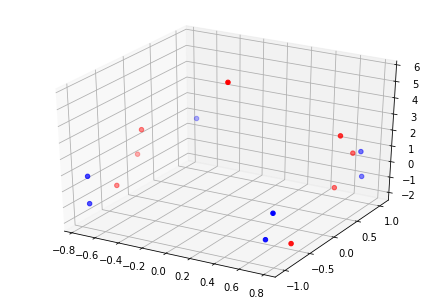

2
******************************
_________ORIG________
[[(0.8100869655609131, 0.9744318127632141, -0.8263795971870422), (0.8043333292007446, -0.9960437417030334, -0.9032723903656006), (0.7815998196601868, 1.0006730556488037, 0.7937742471694946), (0.856910228729248, -0.9749213457107544, 0.8824783563613892), (-0.7790889143943787, -1.035500168800354, -0.8548831343650818), (-0.7889249920845032, 1.0414671897888184, 0.8424216508865356), (-0.8131200671195984, -0.9838007092475891, 0.8391847014427185)]]
_________RECONST________
[[(0.8342768549919128, 0.46052682399749756, -0.5308156609535217), (0.791858434677124, 0.7239203453063965, 1.2254654169082642), (0.7712138891220093, 0.500069260597229, 2.7224879264831543), (0.8719741702079773, -0.5542609691619873, -1.992733120918274), (-0.781020998954773, -0.05278780311346054, 2.096564292907715), (-0.784159243106842, -0.5056627988815308, -0.7082254886627197), (-0.7989586591720581, -0.03081449121236801, 0.3813888728618622), (0.0140080526471138, 0.053501009

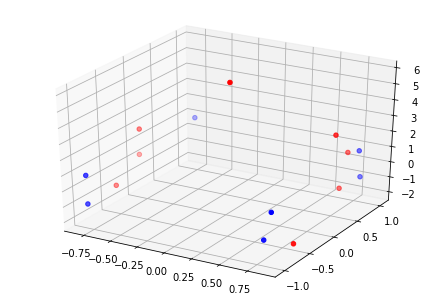

3
******************************
_________ORIG________
[[(0.14912953972816467, 0.3560808598995209, -0.48021262884140015), (0.1480703502893448, -0.3639770448207855, -0.5248937606811523), (0.1438853144645691, 0.36566877365112305, 0.4612639546394348), (0.1577492654323578, -0.3562597930431366, 0.5128117799758911), (-0.14342308044433594, -0.3783954083919525, -0.4967745244503021), (-0.14523380994796753, 0.38057592511177063, 0.48953312635421753), (-0.14968790113925934, -0.35950449109077454, 0.4876537024974823)]]
_________RECONST________
[[(0.1534663438796997, 0.16819466650485992, -0.41675737500190735), (0.14584219455718994, 0.2645912766456604, 0.9986913204193115), (0.14202256500720978, 0.18277566134929657, 2.2303733825683594), (0.16044935584068298, -0.202598437666893, -1.6933242082595825), (-0.1437768191099167, -0.019288543611764908, 1.6575613021850586), (-0.14438283443450928, -0.18480202555656433, -0.5873022079467773), (-0.14715665578842163, -0.011320505291223526, 0.33912938833236694), (0.00

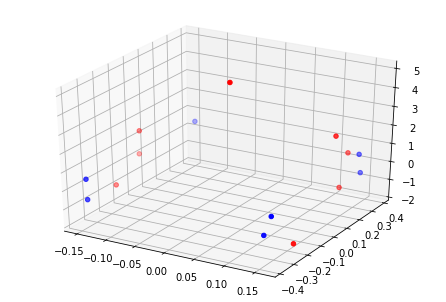

4
******************************
_________ORIG________
[[(0.8735414147377014, 0.6521538496017456, -0.8981115221977234), (0.8673370480537415, -0.6666153073310852, -0.9816757440567017), (0.842822790145874, 0.6697137355804443, 0.8626730442047119), (0.9240323305130005, -0.6524815559387207, 0.9590796828269958), (-0.8401152491569519, -0.6930222511291504, -0.9290861487388611), (-0.8507217764854431, 0.6970157623291016, 0.9155430197715759), (-0.8768120408058167, -0.6584240794181824, 0.9120281338691711)]]
_________RECONST________
[[(0.846450924873352, 0.30109184980392456, -0.5596979260444641), (0.8811976313591003, 0.48816874623298645, 1.2750370502471924), (0.8544031381607056, 0.33774563670158386, 2.826547145843506), (0.9071515798568726, -0.37538793683052063, -2.0580122470855713), (-0.8378908634185791, -0.034758612513542175, 2.187974214553833), (-0.855997622013092, -0.3398178219795227, -0.7343284487724304), (-0.8925846815109253, -0.02478451281785965, 0.38706931471824646), (-0.015650808811187744, 

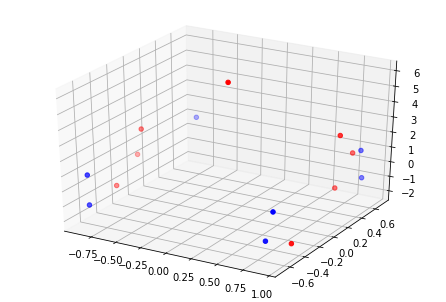

5
******************************
_________ORIG________
[[(0.9323145151138306, 0.016078101471066475, -0.030132709071040154), (0.9256927371025085, -0.016434570774435997, -0.03293634206056595), (0.8995291590690613, 0.016510963439941406, 0.028943661600351334), (0.9862025380134583, -0.016086183488368988, 0.03217826038599014), (-0.8960255980491638, 0.01678621396422386, -0.02918456308543682), (-0.8966394066810608, -0.0170856025069952, -0.031171899288892746), (-0.9079595804214478, 0.0171840600669384, 0.030717510730028152), (-0.9358052611351013, -0.0162326879799366, 0.030599625781178474)]]
_________RECONST________
[[(0.9907093644142151, 0.0007494017481803894, -0.31039249897003174), (0.8955610394477844, 1.7352402210235596e-05, 0.7236607670783997), (0.8743758797645569, -0.0034763822332024574, 1.6070873737335205), (1.0225180387496948, -0.019372202455997467, -1.3266907930374146), (-0.9006894826889038, -0.0020510517060756683, 1.0904757976531982), (-0.8850939869880676, 0.001566404476761818, -0.437345

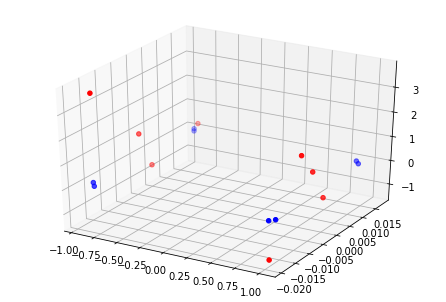

6
******************************
_________ORIG________
[[(0.9382349252700806, 0.7650790214538574, -0.8661271333694458), (0.9315710663795471, -0.7820460796356201, -0.94671630859375), (0.9052413702011108, 0.7856808304786682, 0.8319516181945801), (0.9924651384353638, -0.7654634118080139, 0.9249240756034851), (-0.9023332595825195, -0.8130254745483398, -0.8959996104240417), (-0.9137253165245056, 0.8177105188369751, 0.882938802242279), (-0.941747784614563, -0.7724350094795227, 0.8795480728149414)]]
_________RECONST________
[[(0.8664807081222534, 0.34568434953689575, -0.6210853457450867), (0.9681351780891418, 0.5765523314476013, 1.2908170223236084), (0.9358209371566772, 0.399454802274704, 2.811631917953491), (0.9477345943450928, -0.44508999586105347, -2.075037956237793), (-0.8963690996170044, -0.04015248268842697, 2.153269052505493), (-0.9276152849197388, -0.40012460947036743, -0.737330436706543), (-0.9834020733833313, -0.03346091881394386, 0.3410940170288086), (-0.04089125990867615, 0.032866

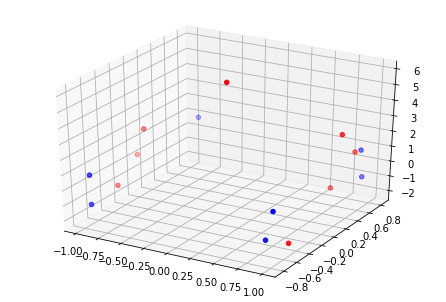

7
******************************
_________ORIG________
[[(0.9759292602539062, 0.5674376487731934, -0.9607089161872864), (0.9689976572990417, -0.5800191760063171, -1.0500965118408203), (0.9416101574897766, 0.5827152132987976, 0.9227994084358215), (1.0323381423950195, -0.5677228569984436, 1.0259264707565308), (-0.9385852217674255, -0.6029958128929138, -0.9938414692878723), (-0.9504349827766418, 0.6064705848693848, 0.9793543815612793), (-0.9795832633972168, -0.5728934407234192, 0.9755954742431641)]]
_________RECONST________
[[(1.0972455739974976, 0.27586549520492554, -0.641918957233429), (0.9058767557144165, 0.4175302982330322, 1.3478702306747437), (0.8889942765235901, 0.2878239154815674, 2.942188024520874), (1.1077039241790771, -0.3179808557033539, -2.1504926681518555), (-0.947998583316803, -0.03133465349674225, 2.272294759750366), (-0.9261860251426697, -0.2929255962371826, -0.7683239579200745), (-0.9080203175544739, -0.013409115374088287, 0.3586650490760803), (0.06908228248357773, 0.035

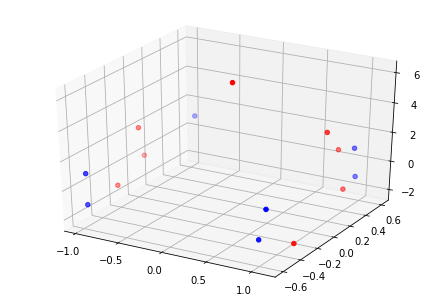

8
******************************
_________ORIG________
[[(0.08020590990781784, 0.9889488816261292, -0.877553403377533), (0.07963624596595764, -1.0108824968338013, -0.9592074751853943), (0.07738541811704636, 1.0155807733535767, 0.8429286479949951), (0.08484182506799698, -0.989445686340332, 0.937126100063324), (-0.0771368220448494, -1.050926685333252, -0.9078217148780823), (-0.07811067998409271, 1.0569827556610107, 0.8945885300636292), (-0.08050621300935745, -0.9984573721885681, 0.8911514282226562)]]
_________RECONST________
[[(0.08989927172660828, 0.478780597448349, -0.6136276125907898), (0.07458306103944778, 0.7287190556526184, 1.2929209470748901), (0.07315562665462494, 0.5025056600570679, 2.8235738277435303), (0.09086532890796661, -0.5554394721984863, -2.078014850616455), (-0.0778922587633133, -0.054439809173345566, 2.166773796081543), (-0.07617561519145966, -0.5109087228775024, -0.7390982508659363), (-0.07479339838027954, -0.02453266829252243, 0.3490419089794159), (0.0055310800671577

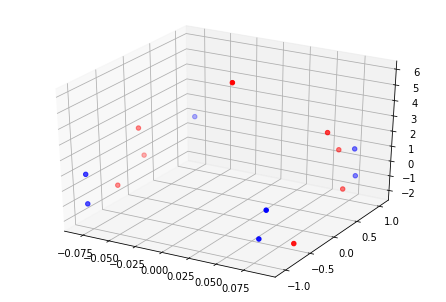

9
******************************
_________ORIG________
[[(0.9054247736930847, 0.2759987711906433, -0.16728754341602325), (0.898993968963623, -0.2821206748485565, -0.18285389244556427), (0.8735849857330322, 0.28343185782432556, 0.160687655210495), (0.9577585458755493, -0.27613744139671326, 0.1786438673734665), (-0.8707786202430725, -0.29329636693000793, -0.17305821180343628), (-0.8817722797393799, 0.29498645663261414, 0.1705355942249298), (-0.9088147878646851, -0.27865245938301086, 0.1698797196149826)]]
_________RECONST________
[[(0.7643067240715027, 0.11801999807357788, -0.37486815452575684), (0.9700677990913391, 0.21140286326408386, 0.8248758912086487), (0.933009922504425, 0.14695461094379425, 1.8113822937011719), (0.869535505771637, -0.16474568843841553, -1.4606688022613525), (-0.8586112260818481, -0.013927694410085678, 1.2656993865966797), (-0.9083478450775146, -0.145612433552742, -0.49008116126060486), (-0.9898197054862976, -0.015929318964481354, 0.26509028673171997), (-0.079363837

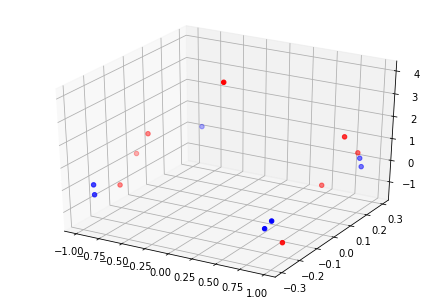

In [1506]:
for i in range(1,10):
    test_reconstruct(i,objs)

In [1460]:
for i in range(1,10):
    plot_obj(i,objs)

[ 0.73573095  0.73050535  0.70985854  0.77825636 -0.70757812 -0.71651137
 -0.73848557] [ 0.97905779 -1.00077283  1.00542402 -0.97954959 -1.04041648  1.04641187
 -0.98847109] [-0.76636577 -0.83767498  0.73612881  0.81839049 -0.79279983  0.78124338
  0.77824092]
[ 0.81008697  0.80433333  0.78159982  0.85691023 -0.77908891 -0.78892499
 -0.81312007] [ 0.97443181 -0.99604374  1.00067306 -0.97492135 -1.03550017  1.04146719
 -0.98380071] [-0.8263796  -0.90327239  0.79377425  0.88247836 -0.85488313  0.84242165
  0.8391847 ]
[ 0.14912954  0.14807035  0.14388531  0.15774927 -0.14342308 -0.14523381
 -0.1496879 ] [ 0.35608086 -0.36397704  0.36566877 -0.35625979 -0.37839541  0.38057593
 -0.35950449] [-0.48021263 -0.52489376  0.46126395  0.51281178 -0.49677452  0.48953313
  0.4876537 ]
[ 0.87354141  0.86733705  0.84282279  0.92403233 -0.84011525 -0.85072178
 -0.87681204] [ 0.65215385 -0.66661531  0.66971374 -0.65248156 -0.69302225  0.69701576
 -0.65842408] [-0.89811152 -0.98167574  0.86267304  0.959

In [1483]:
i=5
x_recovered, y_recovered, z_recovered = model.forward(torch.Tensor(train_xyz_obj[i].unsqueeze(0)).to(device), 
              torch.Tensor(train_xy_conn[i].unsqueeze(0)).to(device), extract_z=True)
z = z_recovered.cpu().detach().tolist()[0]
#y = y_recovered.cpu().detach().tolist()[0]
#x = x_recovered.cpu().detach().tolist()[0]

print(x,"\n\n",y,"\n\n",z)

# trace = go.Mesh3d(x=x,y=y,z=z,color='#0066FF',opacity=0.80)
# py.iplot([trace])

trace = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=12,
        line=dict(
            color='rgb(204, 204, 204)',
            width=0.5
        ),
        opacity=0.8
    )
)

data = [trace]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

tensor([[[ 0.9778,  0.9709,  0.9434,  1.0343, -0.9404, -0.9523, -0.9815,
           0.0000],
         [ 0.9533, -0.9745,  0.9790, -0.9538, -1.0131,  1.0189, -0.9625,
           0.0000],
         [-0.2029, -0.2218,  0.1949,  0.2167, -0.2099,  0.2069,  0.2061,
           0.0000]]]) 

 [ 0.6421333  -0.65637755  0.65942806 -0.64245582 -0.68237865  0.68631083
 -0.6483072 ] 

 [-0.2827427387237549, 0.7096775770187378, 1.5953646898269653, -1.3098256587982178, 1.0879499912261963, -0.4317934513092041, 0.272436261177063, 3.6846680641174316]


In [ ]:
 [-0.23599386 -0.2579518   0.22668184  0.25201425 -0.24413301  0.24057432
  0.23965067]
 [0.1274, 0.1235, 0.1364, -0.0264, -0.121, -0.393, 0.0617, 0.0404]

TEST BY RENDERING

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt


    
def test_reconstruct(N):
    print(N)
    print("******************************")
    fig = plt.figure()
    ax = Axes3D(fig)

    test_obj=test_xyz[N,:,:]
    d,t = test_obj.size()
    obj,conn = torch.Tensor.split(test_obj,[8,t-8],dim=1)
    #print(obj)
    #print(conn)
    fullobj = np.concatenate((obj,conn), axis=1)
    computed_z = model.forward(torch.Tensor([fullobj]).to(device), extract_z=True)
    orig_z = obj[2]


    print("_________ORIG________")

    x=obj[0]
    y=obj[1]
    z=obj[2]


    x=[(i-min(x))/(max(x)-min(x)) for i in x]
    y=[(i-min(y))/(max(y)-min(y)) for i in y]
    z=[(i-min(z))/(max(z)-min(z)) for i in z]

    verts = [list(zip(x, y,z))]
    #ax.add_collection3d(Poly3DCollection(verts))
    ax.scatter(x, y, z, c='r', marker='o')
    plt.show()


    print("_________RECON________")

    fig = plt.figure()
    ax = Axes3D(fig)
    x=obj[0]
    y=obj[1]
    z=computed_z.to('cpu').detach().numpy()[0]
    #print("Test  obj's   z: ", obj[2])
    #print("Model computed z:", z)

    x=[(i-min(x))/(max(x)-min(x)) for i in x]
    y=[(i-min(y))/(max(y)-min(y)) for i in y]
    z=[(i-min(z))/(max(z)-min(z)) for i in z]

    verts = [list(zip(x, y,z))]
    #ax.add_collection3d(Poly3DCollection(verts))
    ax.scatter(x, y, z, c='r', marker='o')
    plt.show()



In [ ]:
N=[15,]

In [ ]:
for i in range(50,60):
    test_reconstruct(i)

In [ ]:
trace = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=12,
        line=dict(
            color='rgb(204, 204, 204)',
            width=0.5
        ),
        opacity=0.8
    )
)

data = [trace]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

Test Performance

In [ ]:
import torch.utils.data
dataset = torch.utils.data.TensorDataset(test_xy[:,:,:], test_xyz[:,:,:])
loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(device)
model.to(device)
criterion = nn.L1Loss()
lr, epochs, batch_size = 1e-1 , 1 , 1
optimizer = torch.optim.SGD(model.parameters(), lr = lr )
accum=[]
i = 0
for k in range(epochs):
    localaccum = []
    for xy, xyz in iter(loader):
        i =  i+1
        local_xy = Variable(xy)
        #print(local_xy)
        local_xyz = Variable(xyz)
        local_xy = local_xy.to(device)
        local_xyz = local_xyz.to(device)
        output = model.forward(local_xy)
        output = output.to(device)
        #print("output:",output)
        #print("actual:", local_xyz[:,2,0:8])
        #loss = criterion(output, local_xyz[:,2,0:8])
        loss = criterion(output, torch.Tensor.new_zeros(output, output.size()))
        
        #print(local_xy, local_xyz)
        #if (i%100 == 0): print("network loss -> ", loss)
        #model.zero_grad()
        #loss.backward()
        #optimizer.step()
        localaccum.append(loss.data[0])
    accum.append(np.mean(localaccum))
plt.plot(localaccum);                                           

In [ ]:
plt.ylabel('SDA')
plt.xlabel('Objects')
plt.ylim((0.06,0.08))
plt.plot(localaccum[0:1000])